<a href="https://colab.research.google.com/github/iliya1984/DevML/blob/main/computer_vision/face_recognition/yale_face_recognition_DLIB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from PIL import Image
import dlib
import cv2
from sklearn.metrics import accuracy_score

from google.colab.patches import cv2_imshow
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
%run '/content/drive/MyDrive/Workspace/Computer Vision/face_recognition/yale_dataset.ipynb'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Common library was successfully loaded
./content/yale_faces/datasets/train directory already exists
./content/yale_faces/datasets/test directory already exists


Image label is "9"


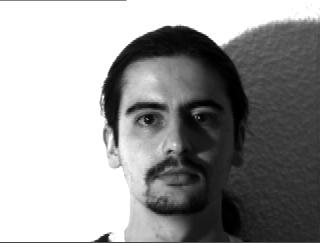

In [43]:
train_set, test_set = YaleDataset.load(preview=True, format='RGB')

In [44]:
points_detector_file_name = 'shape_predictor_68_face_landmarks.dat'
model_file_name = 'dlib_face_recognition_resnet_model_v1.dat'

In [45]:
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor(f'{models_directory}/{points_detector_file_name}')

## Detecting facial points example

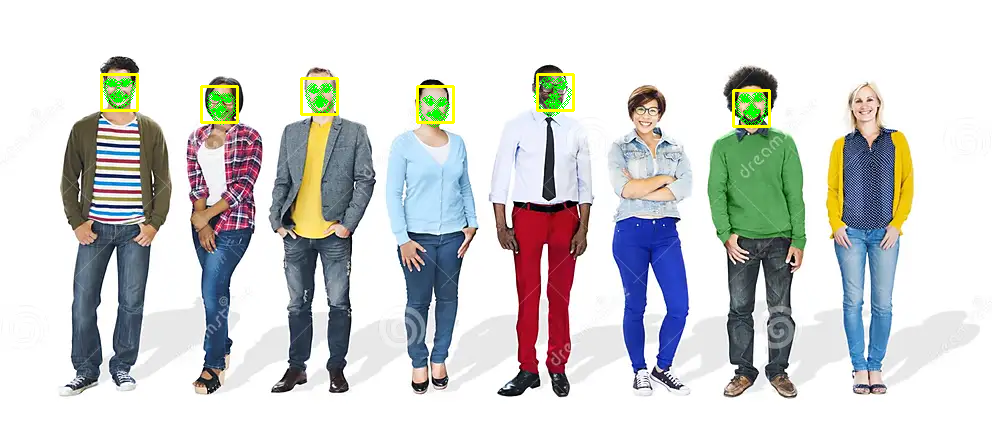

In [46]:
image = CVImage.read(f'{datasets_directory}/sample_images/group-people-standing-row.jpg')

face_rectangles = face_detector(image.to_nparray(), 1)
for rectangle in face_rectangles:
  points = points_detector(image.to_nparray(), rectangle)

  for point in points.parts():
    image.draw_point(point, 2, (0,255,0), 1)

  image.draw_rectangle(rectangle, (0,255,255), 2)

image.show()

## Detecting facial descriptors

In [47]:
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor(f'{models_directory}/{points_detector_file_name}')
face_descriptor_extractor = dlib.face_recognition_model_v1(f'{models_directory}/{model_file_name}')

In [48]:
labels = {}
idx = 0
face_descriptors = None

for train_image in train_set.images:
  image = CVImage(train_image.image)
  face_rectangles = face_detector(image.to_nparray(), 1)
  for rectangle in face_rectangles:
    image.draw_rectangle(rectangle, (0,255,255), 2)
    points = points_detector(image.to_nparray(), rectangle)

    for point in points.parts():
      image.draw_point(point, 2, (0,255,0), 1)

    face_descriptor = face_descriptor_extractor.compute_face_descriptor(image.to_nparray(), points)
    face_descriptor = [f for f in face_descriptor]
    face_descriptor = np.asarray(face_descriptor, dtype=np.float64)
    face_descriptor = face_descriptor[np.newaxis, :]
    if face_descriptors is None:
      face_descriptors = face_descriptor
    else:
      face_descriptors = np.concatenate((face_descriptors, face_descriptor), axis = 0)

    labels[idx] = train_image.label
    idx += 1

In [49]:
face_descriptors.shape

(121, 128)

In [50]:
threshold = 0.5
predictions = []
expected_outputs = []

for test_image in test_set.images:
  image = CVImage(test_image.image)
  face_rectangles = face_detector(image.to_nparray(), 1)
  for rectangle in face_rectangles:
     points = points_detector(image.to_nparray(), rectangle)
     face_descriptor = face_descriptor_extractor.compute_face_descriptor(image.to_nparray(), points)
     face_descriptor = [f for f in face_descriptor]
     face_descriptor = np.asarray(face_descriptor, dtype=np.float64)
     face_descriptor = face_descriptor[np.newaxis, :]

     distances = np.linalg.norm(face_descriptor - face_descriptors, axis = 1)
     min_index = np.argmin(distances)
     min_distance = distances[min_index]

     if min_distance <= threshold:
      name_pred = labels[min_index]
     else:
      name_pred = -1 #'Not identified'

     name_real = test_image.label

     predictions.append(name_pred)
     expected_outputs.append(name_real)

     cv2.putText(image.to_nparray(), 'Pred: ' + str(name_pred), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))
     cv2.putText(image.to_nparray(), 'Exp : ' + str(name_real), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))

predictions = np.array(predictions)
expected_outputs = np.array(expected_outputs)

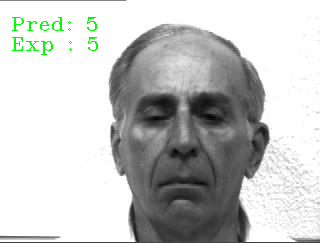

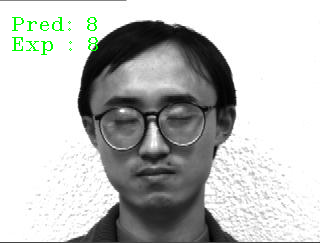

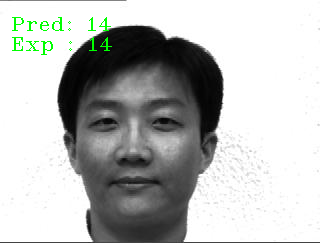

In [53]:
for i in range(3):
  image_preview = test_set.images[i]
  CVImage(image_preview.image).show()

In [52]:
accuracy_score(expected_outputs, predictions)



0.95